In [1]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation, delayed_oscillation
from models import *
from functools import partial

Simulation of one oscillator, from Nat Chem MH

In [13]:
df_fig4_NatChem_MH = pd.read_csv(r'Data_sets\3a_fig4_osc_NatChem_MH.csv')
cut_off, CMC_3a = 5.25, 1.56
tau = 1.15
C_A2tol = df_fig4_NatChem_MH.loc[0, 'cA2'] + df_fig4_NatChem_MH.loc[0, 'cA'] / 2

df_fig4_NatChem_MH[['cA2', 'cA']] /= C_A2tol
df_fig4_NatChem_MH['cS'] /= CMC_3a

for s in ['TA2', 'tS', 'TA']:
    df_fig4_NatChem_MH[s] /= tau

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.92917839 0.00132773 0.14164321]
Initial condition is set as [0.93, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


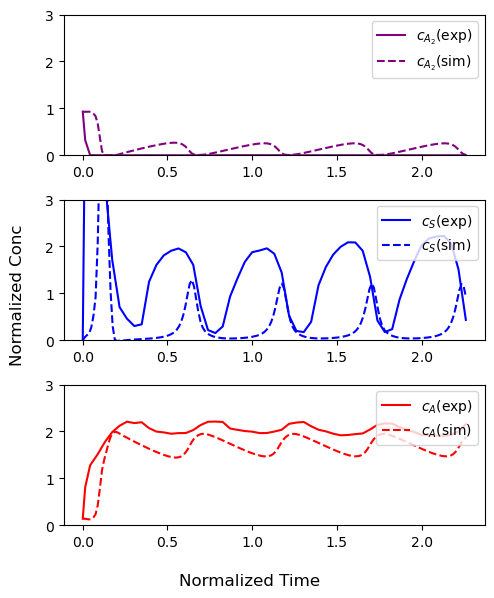

In [14]:
#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 3815, 280, 10, 500, 1e4, 1e4
rext = 12.6
lam, m = 0.11, 2
td1, td2 = 0.03, 0.03

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm / rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0, 0, 0])
delayed_model_fig4 = delayed_oscillation(delayed_full_4vars, delay=delay, params=params, consts=consts, init_cond=init_cond)
delayed_model_fig4.add_exp_data(df_fig4_NatChem_MH)

#The vars in the ODEs are cA2, cS, cO. Which is different from the experiment data. The initial conditions are set manually.
delayed_model_fig4.set_init_cond([0.93, 0, 0, 0])

fig_fig4, ax_fig4 = delayed_model_fig4.plot(ylim=3, nvars=3, exp=True)
#fig.savefig(r'figs\NatChem_MH_fig4.png', dpi=300, bbox_inches='tight')

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2.5602975301781212
        x: [ 3.034e+02  2.252e+01  1.494e+00  3.997e+01]
      nit: 3
      jac: [-2.561e+01  2.103e+01 -3.210e+00  1.139e+01]
     nfev: 140
     njev: 28
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


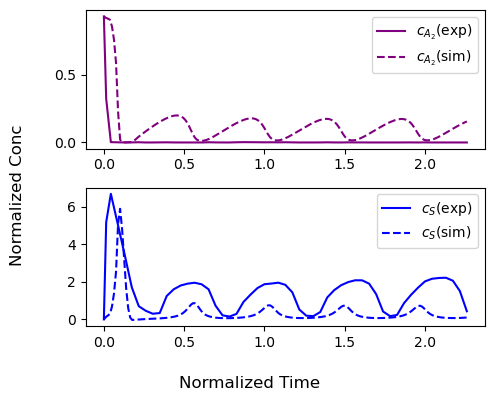

In [16]:
delayed_model_fig4.fit()

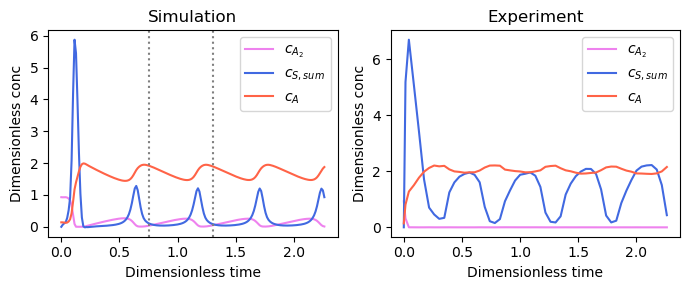

In [217]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
t = ax_fig4[0].lines[1].get_xdata()
ca2_osc = ax_fig4[0].lines[1].get_ydata()
cS_osc = ax_fig4[1].lines[1].get_ydata()
cA_osc = ax_fig4[2].lines[1].get_ydata()

ax[0].plot(t, ca2_osc, c='violet', label='$c_{A_2}$')
ax[0].plot(t, cS_osc, c='royalblue', label='$c_{S,sum}$')
ax[0].plot(t, cA_osc, c='tomato', label='$c_A$')

t_exp = ax_fig4[0].lines[0].get_xdata()
ca2_exp = ax_fig4[0].lines[0].get_ydata()
cS_exp = ax_fig4[1].lines[0].get_ydata()
cA_exp = ax_fig4[2].lines[0].get_ydata()

ax[1].plot(t_exp, ca2_exp, c='violet', label='$c_{A_2}$')
ax[1].plot(t_exp, cS_exp, c='royalblue', label='$c_{S,sum}$')
ax[1].plot(t_exp, cA_exp, c='tomato', label='$c_A$')

ax[0].legend(loc=1)
ax[1].legend(loc=1)

ax[0].axvline(0.75, c='grey', linestyle=':')
ax[0].axvline(1.3, c='grey', linestyle=':')

ax[0].set_ylabel('Dimensionless conc')
ax[1].set_ylabel('Dimensionless conc')
ax[0].set_xlabel('Dimensionless time')
ax[1].set_xlabel('Dimensionless time')

ax[0].set_title('Simulation')
ax[1].set_title('Experiment')
fig.tight_layout()

fig.savefig('figs/sim_vs_exp.png', dpi=300)

In [161]:
soln = delayed_model_fig4.simulate(t=2.5, acc=200)

c:\Users\chem-sedm6967\AppData\Local\anaconda3\envs\jitcdde_clean_env\lib\site-packages\jitcdde\_jitcdde.py:324: UserWarning: The spline already contains points. This will remove them. Be sure that you really want this.
  self.past.constant(state,time)


In [162]:
sol, t = soln

In [163]:
ca2, cs, co, cm = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]
ca = 2 * (1 - ca2) - lam * (cs + cm)

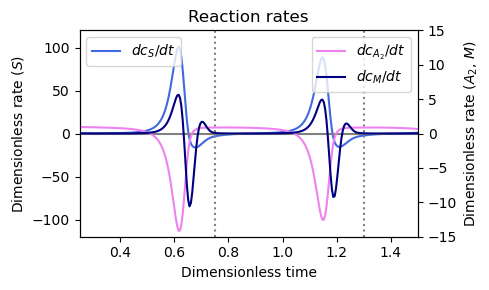

In [165]:
dca2dt = co*ca - alpha * cm * ca2 - theta * ca2
dcsdt = alpha/lam * cm * ca2 + theta/lam * ca2 - phi * cs - delta * (cs**m - cm)
dcmdt = delta * (cs**m - cm) - beta * cm

fig, ax = plt.subplots(figsize=(5,3))

ax.plot(t, dcsdt, label='$dc_{S}/dt$', c='royalblue')

ax2 = ax.twinx()
ax2.plot(t, dca2dt, label='$dc_{A_2}/dt$', c='violet')
ax2.plot(t, dcmdt, label='$dc_{M}/dt$', c='navy')
ax.set_ylim((-120, 120))
ax.set_xlim((0.25, 1.5))
ax2.set_ylim((-15, 15))
ax.legend(loc=2)
ax2.legend(loc=1)
ax.axhline(0, c='grey')

ax.set_ylabel('Dimensionless rate ($S$)')
ax2.set_ylabel('Dimensionless rate ($A_2$, $M$)')
ax.set_xlabel('Dimensionless time')
ax.set_title('Reaction rates')
ax.axvline(0.75, c='grey', linestyle=':')
ax.axvline(1.3, c='grey', linestyle=':')
fig.tight_layout()
fig.savefig('figs/rate.png', dpi=300)

In [67]:
delayed_model_fig4.interactive_plot(exp=True, ran=50)

interactive(children=(FloatSlider(value=302.77777777777777, description='alpha', max=352.77777777777777, min=2…

Steady state

Initial condition is set as [0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


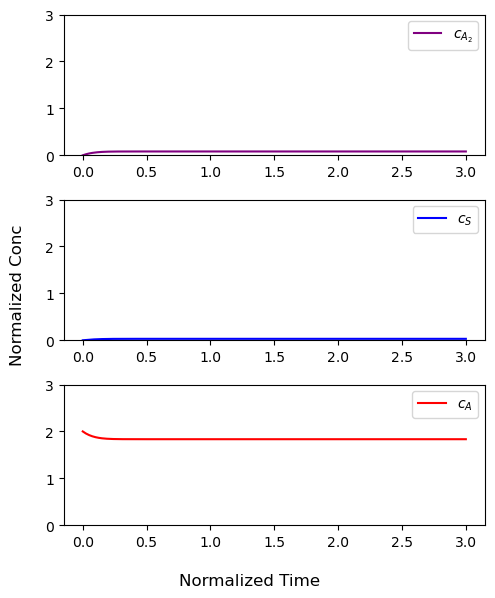

In [4]:
#parameters
rs_ac, rds_ac, rs, rds, ro = 1450, 75, 11, 300, 1e4
rext = 1
lam, m = 0.11, 2
td1, td2 = 0.01, 0.03

#Definition of the model
alpha, beta, theta, phi, ep = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext
params = np.array([alpha, beta, theta, phi, ep])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0, 0, 0])
delayed_model_steady = delayed_oscillation(delayed_full_first_order, delay=delay, params=params, consts=consts, init_cond=init_cond)

#The vars in the ODEs are cA2, cS, cO. Which is different from the experiment data. The initial conditions are set manually.
delayed_model_steady.set_init_cond([0, 0, 0])

fig, axes = delayed_model_steady.plot(ylim=3, nvars=3, t=3)
#fig.savefig(r'figs\steady state.png', dpi=300, bbox_inches='tight')

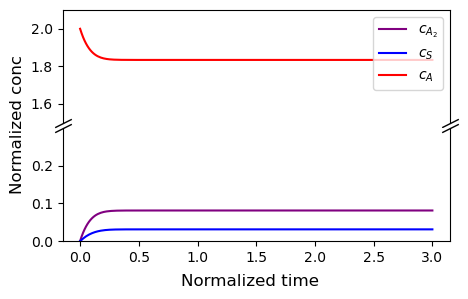

In [13]:
t = axes[0].get_lines()[0].get_xdata()
cA2 = axes[0].get_lines()[0].get_ydata()
cS = axes[1].get_lines()[0].get_ydata()
cA = axes[2].get_lines()[0].get_ydata()
fig, ax = plt.subplots(2, 1, figsize=(5, 3), sharex=True)
fig.subplots_adjust(hspace=0.05)

for a in ax:
    a.plot(t, cA2, label='$c_{A_2}$', color='purple')
    a.plot(t, cS, label='$c_S$', color='blue')
    a.plot(t, cA, label='$c_A$', color='red')

ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].tick_params(bottom=False)

ax[0].set_ylim(1.5, 2.1)
ax[1].set_ylim(0, 0.3)

ax[1].set_yticks([0, 0.1, 0.2])

ax[0].legend(loc=1)

d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

fig.supxlabel('Normalized time', y=-0.05)
fig.supylabel('Normalized conc')
fig.savefig(r'figs\steady state.png', dpi=300, bbox_inches='tight')

Control of oscillation

Oxidant input rate

In [9]:
files = [r'Data_sets/3a_fig3b_25_osc_NatChem_MH.csv', r'Data_sets/3a_fig3b_50_osc_NatChem_MH.csv', r'Data_sets/3a_fig3b_101_osc_NatChem_MH.csv']

df_MH_NatChem_fig3b_25, df_MH_NatChem_fig3b_50, df_MH_NatChem_fig3b_101 = [pd.read_csv(file) for file in files]
df_list = [df_MH_NatChem_fig3b_25, df_MH_NatChem_fig3b_50, df_MH_NatChem_fig3b_101]

cA2_tol = 14.5
CMC_3a = 1.56
tau = [2.1, 1, 0.52]

for tau, df in zip(tau, df_list):
    df['c3a'] /= CMC_3a
    df['Time'] /= tau
    df['t'] /= tau

In [303]:
np.array([13.335714285714285, 11.0, 0.35, 11.65])*28

array([373.4, 308. ,   9.8, 326.2])

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Initial condition is set as [0.9, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


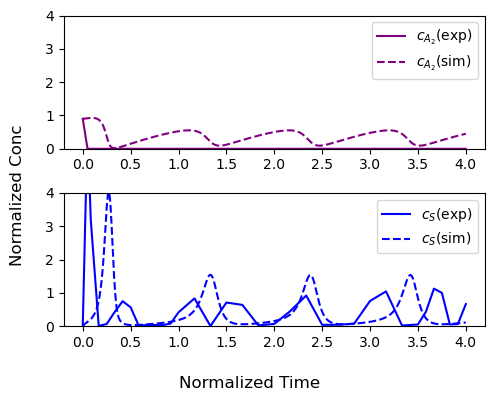

In [10]:
#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 375, 310,  7, 325, 1e4, 1e4
rext = 14
lam, m = 0.11, 2
td1, td2 = 0.03, 0.03

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm/rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0.9, 0, 0, 0])
delayed_model_50 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_50.add_exp_data(df_MH_NatChem_fig3b_50)
delayed_model_50.set_init_cond([0.9, 0, 0, 0])
fig50, axes50 = delayed_model_50.plot(ylim=4, t=4, exp=True)

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Initial condition is set as [0.9, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


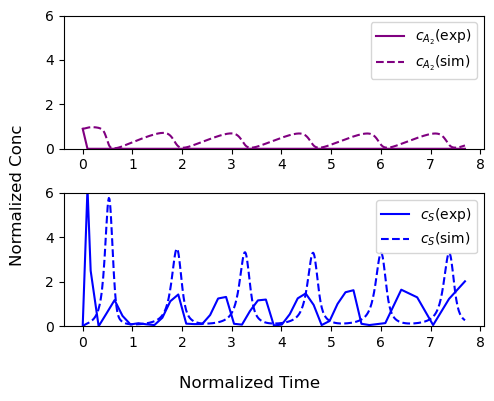

In [307]:
#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 375, 310,  7, 325, 1e4, 1e4
rext = 28
lam, m = 0.11, 2
td1, td2 = 0.06, 0.06

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm/rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0.9, 0, 0])
delayed_model_101 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_101.add_exp_data(df_MH_NatChem_fig3b_101)
delayed_model_101.set_init_cond([0.9, 0, 0, 0])
fig101, axes101 = delayed_model_101.plot(ylim=6, t=8, exp=True)

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Initial condition is set as [0.9, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


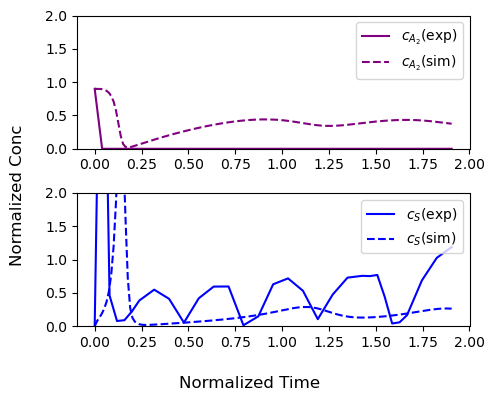

In [ ]:
#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 375, 310,  7, 325, 1e4, 1e4
rext = 7
lam, m = 0.11, 2
td1, td2 = 0.015, 0.015

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm/rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0.9, 0, 0])
delayed_model_25 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_25.add_exp_data(df_MH_NatChem_fig3b_25)
delayed_model_25.set_init_cond([0.9, 0, 0, 0])
fig25, axes25 = delayed_model_25.plot(ylim=2, t=4, exp=True)

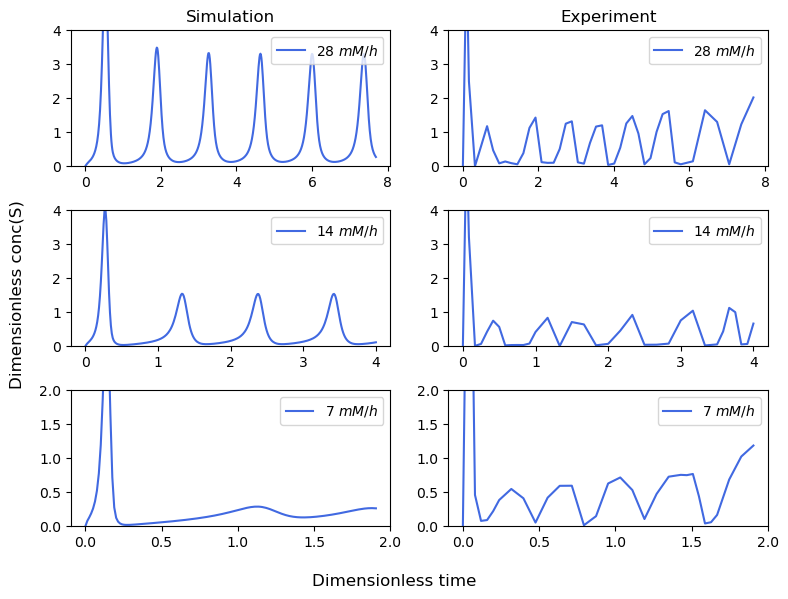

In [311]:
fig, ax = plt.subplots(3, 2, figsize=(8, 6))
axlist = [axes101, axes50, axes25]
legend = ['$28 \ mM/h$', '$14 \ mM/h$', '$7 \ mM/h$']
for r in range(3):
    ax[r, 0].plot(axlist[r][1].lines[1].get_xdata(), axlist[r][1].lines[1].get_ydata(), color='royalblue', label=legend[r])
    ax[r, 0].legend(loc=1)
for r in range(3):
    ax[r, 1].plot(axlist[r][1].lines[0].get_xdata(), axlist[r][1].lines[0].get_ydata(), color='royalblue', label=legend[r])
    ax[r, 1].legend(loc=1)

fig.supylabel('Dimensionless conc(S)')
fig.supxlabel('Dimensionless time')
ax[0, 0].set_title('Simulation')
ax[0, 1].set_title('Experiment')

ax[0, 0].set_ylim(0, 4)
ax[1, 0].set_ylim(0, 4)
ax[2, 0].set_ylim(0, 2)

ax[0, 1].set_ylim(0, 4)
ax[1, 1].set_ylim(0, 4)
ax[2, 1].set_ylim(0, 2)
plt.tight_layout()

fig.savefig(r'figs\h2o2 input.png', dpi=300, bbox_inches='tight')

Stirring rate

In [2]:
files = [r'Data_sets\3a_fig2d_300rpm_osc_Chem_MH.csv', r'Data_sets\3a_fig2d_600rpm_osc_Chem_MH.csv', r'Data_sets\3a_fig2d_1200rpm_osc_Chem_MH.csv']

df_MH_Chem_fig2d_300rpm, df_MH_Chem_fig2d_600rpm, df_MH_Chem_fig2d_1200rpm = [pd.read_csv(file) for file in files]
df_list = [df_MH_Chem_fig2d_300rpm, df_MH_Chem_fig2d_600rpm, df_MH_Chem_fig2d_1200rpm]

cA2_tol = 14.5
CMC_3a = 1.56
rext = 14
tau = cA2_tol / rext

for df in df_list:
    df['cS'] /= CMC_3a
    df['tS'] /= tau
    df['tA2'] /= tau

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0. 0.]
Initial condition is set as [0, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


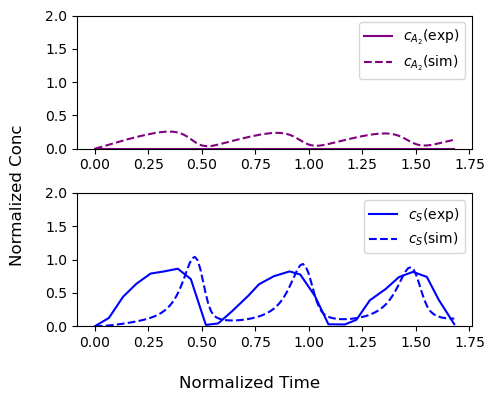

In [3]:
#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 1320, 870, 12.5, 210, 1e4, 1e4
rext = 14
lam, m = 0.11, 2
td1, td2 = 0.03, 0.03

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm / rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])

init_cond = np.array([0, 0, 0, 0])
delayed_model_stirr1 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_stirr1.add_exp_data(df_MH_Chem_fig2d_300rpm)
delayed_model_stirr1.set_init_cond([0, 0, 0, 0])
fig1, axes1 = delayed_model_stirr1.plot(ylim=2, t=3, exp=True)

c:\Users\chem-sedm6967\AppData\Local\anaconda3\envs\jitcdde_clean_env\lib\site-packages\jitcdde\_jitcdde.py:324: UserWarning: The spline already contains points. This will remove them. Be sure that you really want this.
  self.past.constant(state,time)
c:\Users\chem-sedm6967\OneDrive - Nexus365\Desktop\01_projects\01_oscillation modelling\Chemical_Oscillation_Model\osc_toolkit.py:283: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


alpha = 94.286, beta = 62.143, theta = 0.893, phi = 15.000
alpha = 94.286, beta = 62.143, theta = 0.893, phi = 15.000
alpha = 94.286, beta = 62.143, theta = 0.893, phi = 15.000
alpha = 94.286, beta = 62.143, theta = 0.893, phi = 15.000
alpha = 94.286, beta = 62.143, theta = 0.893, phi = 15.000
alpha = 94.477, beta = 62.402, theta = 1.812, phi = 15.227
alpha = 94.477, beta = 62.402, theta = 1.812, phi = 15.227
alpha = 94.477, beta = 62.402, theta = 1.812, phi = 15.227
alpha = 94.477, beta = 62.402, theta = 1.812, phi = 15.227
alpha = 94.477, beta = 62.402, theta = 1.812, phi = 15.227
alpha = 94.358, beta = 62.241, theta = 1.241, phi = 15.086
alpha = 94.358, beta = 62.241, theta = 1.241, phi = 15.086
alpha = 94.358, beta = 62.241, theta = 1.241, phi = 15.086
alpha = 94.358, beta = 62.241, theta = 1.241, phi = 15.086
alpha = 94.358, beta = 62.241, theta = 1.241, phi = 15.086
alpha = 94.434, beta = 62.171, theta = 1.290, phi = 15.035
alpha = 94.434, beta = 62.171, theta = 1.290, phi = 15.0

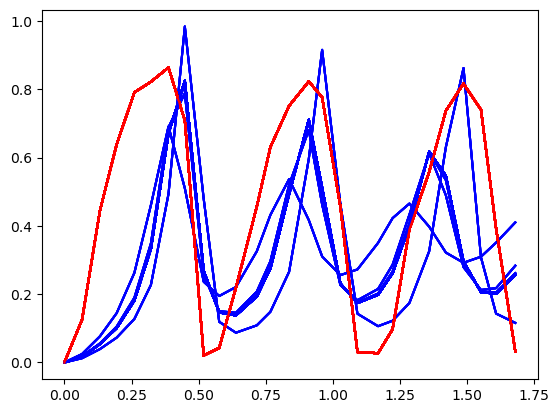

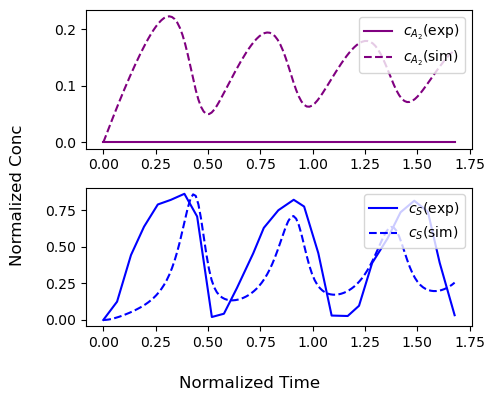

In [4]:
delayed_model_stirr1.fit()

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0. 0.]
Initial condition is set as [0, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


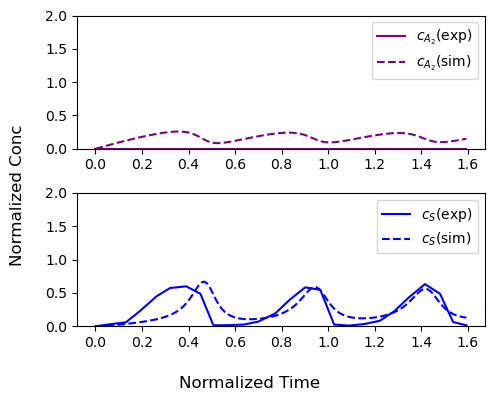

In [5]:
#Faster stirring
k1 = 1.1
k2 = 1.4
n = 2

#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 1320, 870, 12.5, 210, 1e4, 1e4
rext = 14
lam, m = 0.11, 2
td1, td2 = 0.03, 0.03

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac * k1 / rext, rds_ac * k2 / rext, rs * k1 / rext, rds * k2 / rext, ro / rext, rm/rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2]) / n

init_cond = np.array([0, 0, 0])
delayed_model_stirr2 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_stirr2.add_exp_data(df_MH_Chem_fig2d_600rpm)
delayed_model_stirr2.set_init_cond([0, 0, 0, 0])
fig2, axes2 = delayed_model_stirr2.plot(ylim=2, t=3, exp=True)

alpha = 103.714, beta = 87.000, theta = 0.982, phi = 21.000
alpha = 103.714, beta = 87.000, theta = 0.982, phi = 21.000
alpha = 103.714, beta = 87.000, theta = 0.982, phi = 21.000
alpha = 103.714, beta = 87.000, theta = 0.982, phi = 21.000
alpha = 103.714, beta = 87.000, theta = 0.982, phi = 21.000
alpha = 103.512, beta = 86.964, theta = 1.954, phi = 21.115
alpha = 103.512, beta = 86.964, theta = 1.954, phi = 21.115
alpha = 103.512, beta = 86.964, theta = 1.954, phi = 21.115
alpha = 103.512, beta = 86.964, theta = 1.954, phi = 21.115
alpha = 103.512, beta = 86.964, theta = 1.954, phi = 21.115
alpha = 103.643, beta = 86.987, theta = 1.327, phi = 21.041
alpha = 103.643, beta = 86.987, theta = 1.327, phi = 21.041
alpha = 103.643, beta = 86.987, theta = 1.327, phi = 21.041
alpha = 103.643, beta = 86.987, theta = 1.327, phi = 21.041
alpha = 103.643, beta = 86.987, theta = 1.327, phi = 21.041
alpha = 103.703, beta = 86.998, theta = 1.036, phi = 21.006
alpha = 103.703, beta = 86.998, theta = 

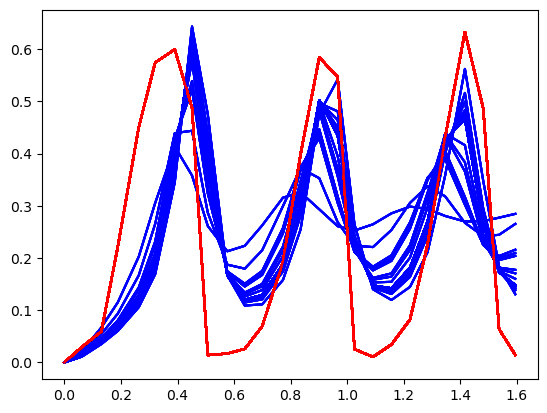

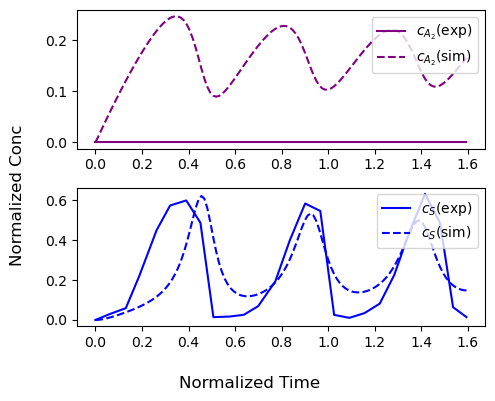

In [6]:
delayed_model_stirr2.fit()

c:\Users\chem-sedm6967\AppData\Local\anaconda3\envs\jitcdde_clean_env\lib\site-packages\jitcdde\_jitcdde.py:324: UserWarning: The spline already contains points. This will remove them. Be sure that you really want this.
  self.past.constant(state,time)


(<Figure size 500x400 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

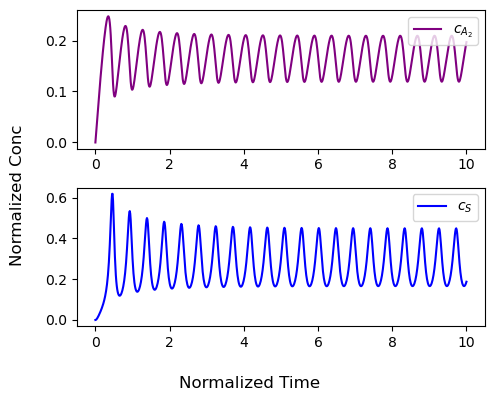

In [11]:
delayed_model_stirr2.plot(t=10)

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0. 0.]
Initial condition is set as [0, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


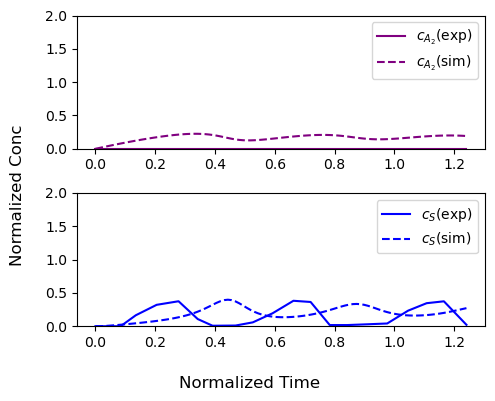

In [ ]:
#More faster stirring
k1 = 1.6
k2 = 1.8
n = 2.5

#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 1320, 870, 12.5, 210, 1e4, 1e4
rext = 14
lam, m = 0.11, 2
td1, td2 = 0.03, 0.03

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac * k1 / rext, rds_ac * k2 / rext, rs * k1 / rext, rds * k2 / rext, ro / rext, rm/rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2]) / n

init_cond = np.array([0, 0, 0])
delayed_model_stirr3 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_stirr3.add_exp_data(df_MH_Chem_fig2d_1200rpm)
delayed_model_stirr3.set_init_cond([0, 0, 0, 0])
fig3, axes3 = delayed_model_stirr3.plot(ylim=2, t=6, exp=True)

alpha = 128.000, beta = 111.857, theta = 1.429, phi = 27.000
alpha = 128.000, beta = 111.857, theta = 1.429, phi = 27.000
alpha = 128.000, beta = 111.857, theta = 1.429, phi = 27.000
alpha = 128.000, beta = 111.857, theta = 1.429, phi = 27.000
alpha = 128.000, beta = 111.857, theta = 1.429, phi = 27.000
alpha = 127.419, beta = 111.371, theta = 1.676, phi = 26.913
alpha = 127.419, beta = 111.371, theta = 1.676, phi = 26.913
alpha = 127.419, beta = 111.371, theta = 1.676, phi = 26.913
alpha = 127.419, beta = 111.371, theta = 1.676, phi = 26.913
alpha = 127.419, beta = 111.371, theta = 1.676, phi = 26.913
alpha = 127.360, beta = 111.504, theta = 1.765, phi = 26.925
alpha = 127.360, beta = 111.504, theta = 1.765, phi = 26.925
alpha = 127.360, beta = 111.504, theta = 1.765, phi = 26.925
alpha = 127.360, beta = 111.504, theta = 1.765, phi = 26.925
alpha = 127.360, beta = 111.504, theta = 1.765, phi = 26.925
alpha = 127.269, beta = 111.636, theta = 1.778, phi = 27.013
alpha = 127.269, beta = 

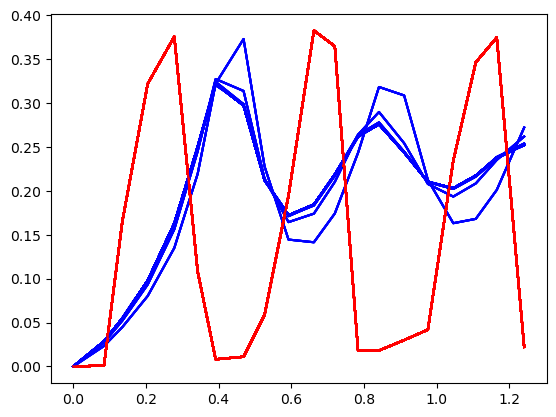

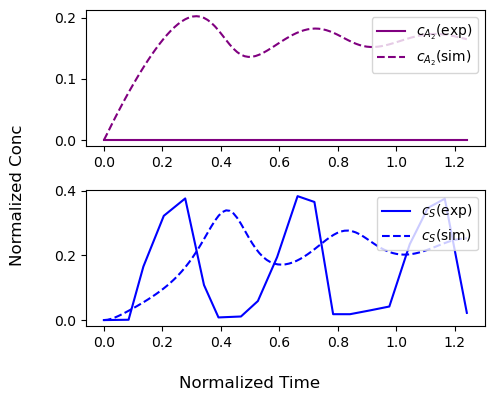

In [10]:
delayed_model_stirr3.fit()

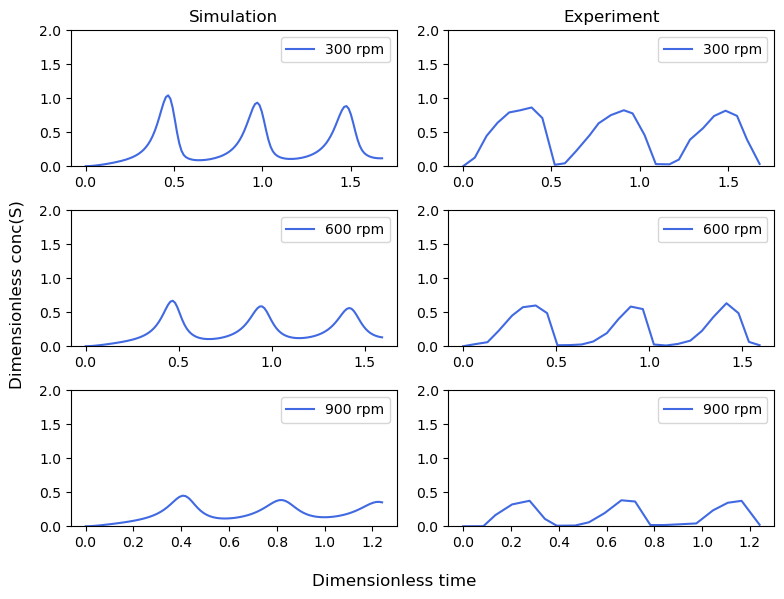

In [320]:
fig, ax = plt.subplots(3, 2, figsize=(8, 6))
axlist = [axes1, axes2, axes3]
legend = ['300 rpm', '600 rpm', '900 rpm']
for r in range(3):
    ax[r, 0].plot(axlist[r][1].lines[1].get_xdata(), axlist[r][1].lines[1].get_ydata(), color='royalblue', label=legend[r])
    ax[r, 0].legend(loc=1)
for r in range(3):
    ax[r, 1].plot(axlist[r][1].lines[0].get_xdata(), axlist[r][1].lines[0].get_ydata(), color='royalblue', label=legend[r])
    ax[r, 1].legend(loc=1)
fig.supylabel('Dimensionless conc(S)')
fig.supxlabel('Dimensionless time')
ax[0, 0].set_title('Simulation')
ax[0, 1].set_title('Experiment')

ax[0, 0].set_ylim(0, 2)
ax[1, 0].set_ylim(0, 2)
ax[2, 0].set_ylim(0, 2)

ax[0, 1].set_ylim(0, 2)
ax[1, 1].set_ylim(0, 2)
ax[2, 1].set_ylim(0, 2)
plt.tight_layout()

fig.savefig(r'figs\stirring.png', dpi=300, bbox_inches='tight')

DMAP conc

In [2]:
files = [r'Data_sets\3a_fig3a_2pctg_osc_NatChem_MH.csv', r'Data_sets\3a_fig3a_20pctg_osc_NatChem_MH.csv', r'Data_sets\3a_fig3a_200pctg_osc_NatChem_MH.csv', r'Data_sets\3a_fig3a_400pctg_osc_NatChem_MH.csv']

df_MH_Chem_fig3a_2pctg, df_MH_Chem_fig3a_20pctg, df_MH_Chem_fig3a_200pctg, df_MH_Chem_fig3a_400pctg = [pd.read_csv(file) for file in files]
df_list = [df_MH_Chem_fig3a_2pctg, df_MH_Chem_fig3a_20pctg, df_MH_Chem_fig3a_200pctg, df_MH_Chem_fig3a_400pctg]

cA2_tol = 14.5
CMC_3a = 1.56
rext = 12.6
tau = cA2_tol / rext

for df in df_list:
    df['cS'] /= CMC_3a
    df['timeS'] /= tau
    df['timeA2'] /= tau

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Initial condition is set as [0.9, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


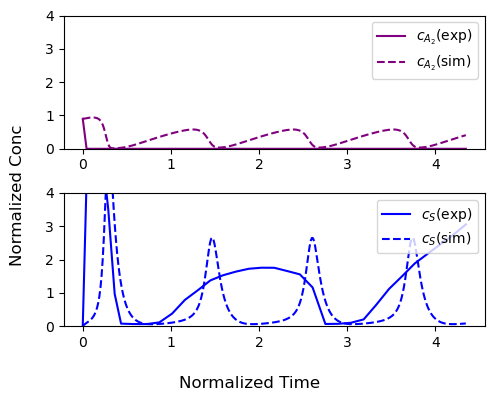

In [322]:
#DMAP 2 mol%
k1 = 1
k2 = 1

#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 315, 75, 5.3, 280, 1e4, 1e4
rext = 12.6
lam, m = 0.11, 2
td1, td2 = 0.03, 0.03

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac * k1 / rext, rds_ac * k2 / rext, rs * k1 / rext, rds * k2 / rext, ro / rext, rm/rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])

init_cond = np.array([0.9, 0, 0])
delayed_model_dmap_2pct = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_dmap_2pct.add_exp_data(df_MH_Chem_fig3a_2pctg)
delayed_model_dmap_2pct.set_init_cond([0.9, 0, 0, 0])
fig1, axes1 = delayed_model_dmap_2pct.plot(ylim=4, t=4, exp=True)

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Initial condition is set as [0.9, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


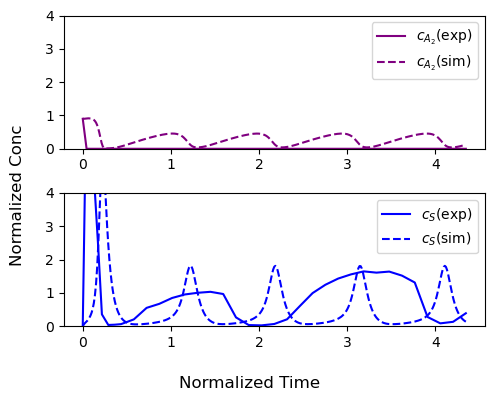

In [323]:
#DMAP 20 mol%
k1 = 1.5
k2 = 1.2

#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 315, 75, 5.3, 280, 1e4, 1e4
rext = 12.6
lam, m = 0.11, 2
td1, td2 = 0.03, 0.03

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac * k1 / rext, rds_ac * k2 / rext, rs * k1 / rext, rds * k2 / rext, ro / rext, rm/rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])

init_cond = np.array([0.9, 0, 0])
delayed_model_dmap_20pct = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_dmap_20pct.add_exp_data(df_MH_Chem_fig3a_20pctg)
delayed_model_dmap_20pct.set_init_cond([0.9, 0, 0, 0])
fig2, axes2 = delayed_model_dmap_20pct.plot(ylim=4, t=4, exp=True)

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Initial condition is set as [0.9, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


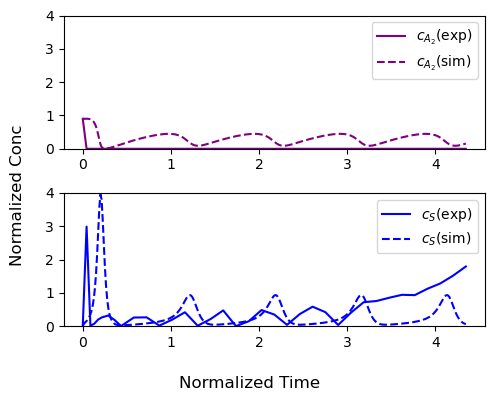

In [324]:
#DMAP 200 mol%
k1 = 2
k2 = 1.8

#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 315, 75, 5.3, 280, 1e4, 1e4
rext = 12.6
lam, m = 0.11, 2
td1, td2 = 0.03, 0.03

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac * k1 / rext, rds_ac * k2 / rext, rs * k1 / rext, rds * k2 / rext, ro / rext, rm/rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])

init_cond = np.array([0.9, 0, 0])
delayed_model_dmap_200pct = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_dmap_200pct.add_exp_data(df_MH_Chem_fig3a_200pctg)
delayed_model_dmap_200pct.set_init_cond([0.9, 0, 0, 0])
fig3, axes3 = delayed_model_dmap_200pct.plot(ylim=4, t=4, exp=True)

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Initial condition is set as [0.9, 0, 0, 0]
Generating, compiling, and loading C code.
Using default integration parameters.


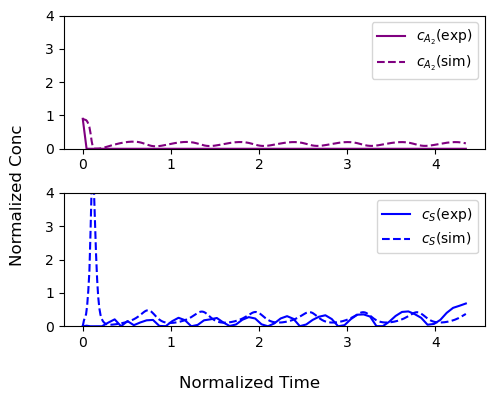

In [325]:
#DMAP 400 mol%
k1 = 5
k2 = 2

#parameters
rs_ac, rds_ac, rs, rds, ro, rm = 315, 75, 5.3, 280, 1e4, 1e4
rext = 12.6
lam, m = 0.11, 2
td1, td2 = 0.03, 0.03

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac * k1 / rext, rds_ac * k2 / rext, rs * k1 / rext, rds * k2 / rext, ro / rext, rm/rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])

init_cond = np.array([0.9, 0, 0])
delayed_model_dmap_400pct = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_dmap_400pct.add_exp_data(df_MH_Chem_fig3a_400pctg)
delayed_model_dmap_400pct.set_init_cond([0.9, 0, 0, 0])
fig4, axes4 = delayed_model_dmap_400pct.plot(ylim=4, t=4, exp=True)

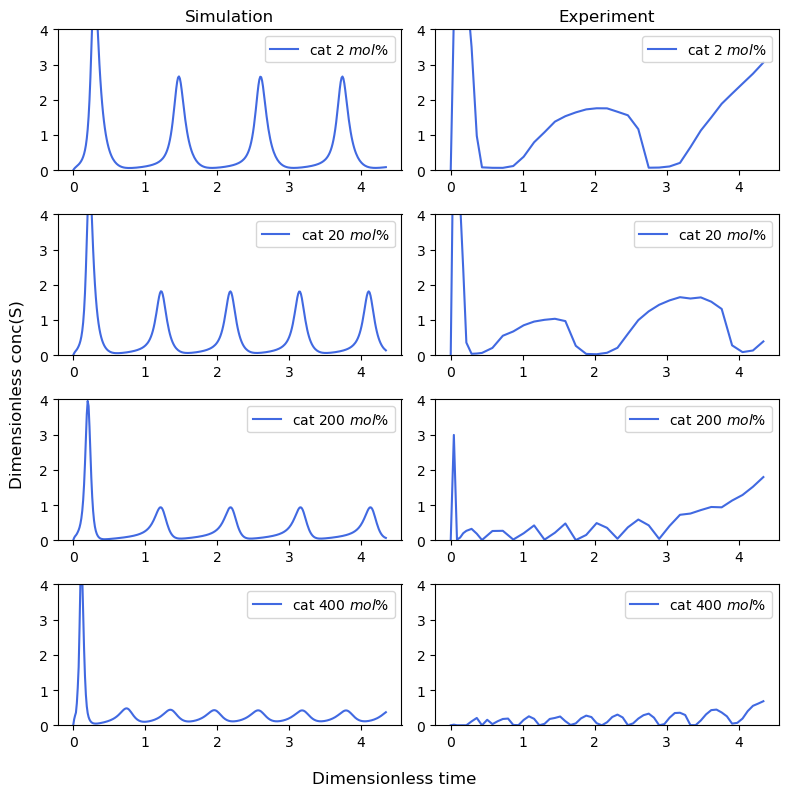

In [330]:
fig, ax = plt.subplots(4, 2, figsize=(8, 8))
axlist = [axes1, axes2, axes3, axes4]
legend = ['$2 \ mol\%$', '$20 \ mol\%$', '$200 \ mol\%$', '$400 \ mol\%$']
for r in range(4):
    ax[r, 0].plot(axlist[r][1].lines[1].get_xdata(), axlist[r][1].lines[1].get_ydata(), color='royalblue', label='cat '+ legend[r])
    ax[r, 0].legend(loc=1)
    ax[r, 0].set_ylim(0, 4)
for r in range(4):
    ax[r, 1].plot(axlist[r][1].lines[0].get_xdata(), axlist[r][1].lines[0].get_ydata(), color='royalblue', label='cat '+ legend[r])
    ax[r, 1].legend(loc=1)
    ax[r, 1].set_ylim(0, 4)

fig.supylabel('Dimensionless conc(S)')
fig.supxlabel('Dimensionless time')
ax[0, 0].set_title('Simulation')
ax[0, 1].set_title('Experiment')

plt.tight_layout()

fig.savefig(r'figs\dmap.png', dpi=300, bbox_inches='tight')